# Day 18 Pre-Class: Viral Kinetics

### <p style="text-align: right;"> &#9989; Cesarine Graham</p>

### Goals for today's pre-class assignment:
* Practice using `solve_ivp` to build a viral kinetics model
* Once you have a functioning model, explore the impact that various parameters have on the model's behavior

### Assignment instructions

**This assignment is due by 11:59 p.m. the day before class,** and should be uploaded into the appropriate "Pre-class assignments" submission folder.  Submission instructions can be found at the end of the notebook.
____

Before we get started, we're going to import all of the necessary libraries. Note that we're using [**SciPy**](https://www.scipy.org/)'s `solve_ivp` package, we've worked with recently. `solve_ivp` accurately and quickly solves wide classes of ODEs. Make sure you execute the cell!

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

# Note that the SciPy library is needed for solve_ivp
from scipy.integrate import solve_ivp

---
Now, execute the cell below and watch the video about **Ordinary Differential Equations (ODEs) and Compartmental Modeling**. Compartmental models are really useful when we can divide up a system into distinct populations or quantities and then define equations for how those populations/quantities evolve and interact. After you watch the video, you'll have a chance to build your own compartmental model to understand how viruses spread.

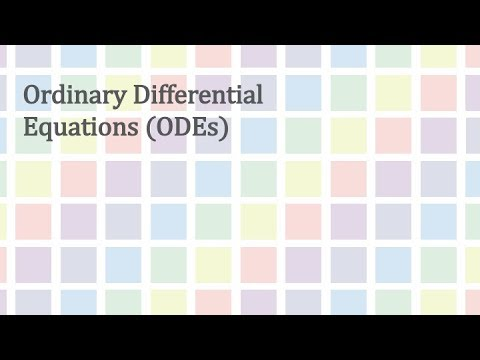

In [2]:
from IPython.display import YouTubeVideo 
YouTubeVideo("0N3qB5vaJhA",width=640,height=360)

### Now that we know a bit more about compartmental models, let's dig into the following model for Viral Infections!

<img src="http://www.frontiersin.org/files/Articles/32842/fmicb-03-00319-HTML/image_m/fmicb-03-00319-g001.jpg" height=700 width = 600>

____
# Viral Infections
____

Viral infections are one the main causes of disease in humans and recently have been the reason behind the global COVID-19 pandemic. Along with bacteria and parasite infections, viral infections are caused by the introduction of a microscopic "organism" into our bodies. Sometimes these viruses live in our bodies throughout our lifetime with little damage; sometimes, they quickly kill us. 

We would like to build a model for how viruses infected the cells of our body. We will consider an infection in which our immune system is able to clear the virus. Since winter is coming, consider this to be the influenza virus. 

How do viruses work? We need to understand a bit about this in order to build our model. The most important feature is that viruses cannot reproduce on their own - that is what they need you for. Your body, to a virus, is simply a factory for making and spreading more of them. If virions were writing the history books, humans would simply be their maternity ward. The way this works is that virions enter your cells, where there is a factory at work to keep the cell functioning, and they give all of the factory workers new instructions. A factory that was making cars, once the virions enter, is now making laptops; or, in this case, rather than keeping the cell alive and healthy, the machinery of the cells makes more virions. For every virion that enters a cell, that cell might make hundreds of new virions, leading to a population explosion. Your body will need to quickly mount an immune response to keep this under control. 

What compartments might we need? (Look at the picture above.)
* **T**arget cells; these are the healthy cells the virion might enter
* **I**nfected cell; these cells produce new virions, and might die over time
* **V**irion population; the number of virions at any given time during the infection

What parameters will we need?
* rate at which cells become infected: this reduces the value of T and increases the value of I
* the production rate of new virions, which increases the value of V
* rate at which infected cells die
* rate at which virions degrade and leave the system


____
### Viral Kinetics (VK) Model
____

A simple model is then:
$$\frac{dT}{dt} = -\beta TV,$$ 

$$\frac{dI}{dt} = \beta TV - \delta I,$$ 

$$\frac{dV}{dt} = pI - rV.$$

Models like this are called "viral kinetics" models, or **VK** for short. Note that due to terms like $TV$, these are non-linear ODEs and almost never have simply solution: we need a computational approach. But, because this is so incredibly common, nice Python libraries make this super easy.

____
### REVIEW: Setting up `solve_ivp()`

Let's pause our focus on VK modeling to examine how we can set up all problems of this type.

You've already spent some time working with `solve_ivp()`, but we're including the following information to provide a more detailed framework for how you can think about using `solve_ivp()` to solve a system of ODEs. Watch the video in the cell below for a review!

## Click on the link to watch the video with Mediaspace

[Video for a review of solve_ivp()](https://mediaspace.msu.edu/media/Rachel+Frisbie+%28she+her%29%27s+Personal+Meeting+Room/1_kr9qqpas) via Mediaspace!


-----
To solve the ODE model we will use the `solve_ivp()` library. This library solves ODEs using very accurate algorithms, far more powerful than the simple "update equation" method we've used previously. 

In Summary:

1. Define derivative function
    * Express your model in terms of ODEs
    * Function must have time (independent variable) as first argument
    * Must have y as second argument (y contains all of your unknowns of interest; if you have 4 differential equations, you have 4 values in y)
    * Should return derivatives in same order as y (if you have 4 differential equations, this returns 4 derivatives) 
2. Initialize y (initial conditions)
    * y is a list/array of initial values for all of your unknowns
3. Set time array
    * array of locations/times of your independent variable for which you want to know the value of y
4. Call `solve_ivp()`
    * Returns solution (values of y for each time).

Importantly, `solve_ivp()` has no idea what _your_ ODEs are, so it must provide a structure that can work for almost everyone's computational model. Once you learn this structure, you can easily use `solve_ivp()` for almost all of your ODE models. Modeling with ODEs then becomes these steps:
1. develop your model, perhaps using the compartmental modeling approach
2. transform the ODE model into the standard form `solve_ivp()` uses universally
3. follow the steps above to write your code

In the exercise below, our VK model has been developed and we have our ODEs, so we can go straight to writing code!

<!--Most mathematical libraries follow a simple format: you pass something in and it passes something back to you. A very simple example is `sin(x)`; you send it `x` and it gives you back `sin(x)` using some unknown-to-us algorithm. However, there are libraries that follow a different format because they involve us defining functions. One example is finding the roots (zeros) of an equation, as in `f(x) = 0`. In this case we need to tell Python what `f(x)` is before it can help us. Another example is fitting data to a model with a specific form; again, we need to tell Python what our model is in advance by creating a function that is based our model (then we can pass this function to something like `curve_fit`).

In the case of ODEs, we need to somehow give Python our ODEs and then tell `solve_ivp` to solve those. This is handled with `solve_ivp` in the following seven-step process:
1. **express your model** in terms of a system of ODEs (where changes in quantities are equal to gains minus losses)
2. **define a function** (using `def`) that accepts the following input arguments:  the independent variable (e.g., time), the current values of the variables, and any additional parameters needed for the ODE model. The function should compute and return the derivatives for the ODE model using the input arguments.
3. **set up the initial conditions** for your ODE model
4. **decide how many steps** you would like to take to get the solution
5. **define any parameters** that appear in your model
6. **call the `solve_ivp` library** and pass as arguments the name of your function, the initial conditions, the time values for the model results, and all necessary equation parameters (using the `args` arguments for the `solve_ivp`, which must be given a tuple)
7. **process the results** as needed, usually starting with plotting the results


. -->

___
#### If you would like to review a worked example to help build your model, scroll down to the end of this notebook. At this point we've already done some ODE modeling, so we're going to charge forward with our VK model!

____
### Time to write some code!
____

Using this template, fill in your code below for the VK model given above. Here it is again, so that you don't need to keep scrolling up and down:
$$\frac{dT}{dt} = -\beta TV,$$

$$\frac{dI}{dt} = \beta TV - \delta I,$$

$$\frac{dV}{dt} = pI - rV.$$


____
#### Step 1: Setting up the ODEs

The comparmental model is given to you, and it has already been converted to ODEs in the form `solve_ivp` wants (see the equations above); you just need to complete the remaining steps.

____
#### Step 2: Define the derivatives function
____

In [3]:
# STEP 2: define the function that contains the derivatives
def derivs(t, curr_vals, beta, delta, p, r):
    """
    Calculate the LHS of the above equations

    Input
    -----
    t : array, list, or scalar float
        Time in sec

    curr_vals : array,
        Current values of the LHS

    beta : float
        Infection rate

    delta : float
        Death rate

    p : float
        Production rate

    r : float
        Degradation rate

    Return
    ------
    Fill in this part
    """

    # unpack list of incoming variables
    target = curr_vals[0]
    infected = curr_vals[1]
    virions = curr_vals[2]

    # use variables to compute derivatives on the right-hand-side of the above equations
    # example: dTdt = < equation from above >
    dTdt = - beta*curr_vals[0]*curr_vals[2]
    dIdt = beta*curr_vals[0]*curr_vals[2]-delta*curr_vals[1]
    dVdt = p*curr_vals[1]-r*curr_vals[2]

    # return the derivatives in a list by changing the "pass" to "return" along with the correct list
    return [dTdt, dIdt, dVdt]

____
#### Step 3: Define initial conditions

Since you might not have a sense for a reasonable set of initial conditions for this problem. We've defined some for you.
____

In [4]:
# STEP 3: define the initial conditions
target_0 = 4e8
infected_0 = 0.0
virions_0 = 1.0
# Here we put them all into a list so that they can be passed to solve_ivp
initial = [target_0, infected_0, virions_0]

___
#### Step 4: Define interval over which we want a solution

Think about how long you run to run your model for and choose a time range as well as the number of time increments you want. You may end up coming back to tweak this once you run your model if the results don't end up very interesting or don't make sense. The easiest way to create this array of time values is by using NumPy!
___

In [5]:
# STEP 4: add time array here 
t = np.linspace(0,10,1000)

___
#### Step 5: Define the parameters of the model

Again, since you might not have a good sense for what some reasonable choices might be, we've provided some as a starting point for your exploration.
___

In [6]:
# STEP 5: define model parameters here
beta = 1e-5
delta = 4.0
p = 1e-2
r = 1

____
#### Step 6: Call `solve_ivp` to get a solution.
____

In [7]:
# STEP 6: pass everything to `solve_ivp`, store the solution, and unpack it
# into a useful set of lists/arrays for later use
# Make sure to pass _all_ of the model parameters from Step 5 as a tuple to "args"

sol = solve_ivp(derivs, (0,10),initial,t_eval = t, args=(beta, delta, p, r))
tar = sol.y[0,:]
inf = sol.y[1,:]
vir = sol.y[2,:]

____
#### Step 7: Visualize Results
____
Make a quad plot, using `subplot`, that contains:
* target cell population versus time
* viral load versus time
* infected cell population versus time
* a [3D plot](https://matplotlib.org/tutorials/toolkits/mplot3d.html) of V versus T and I (some code for this has been provided for you)

Make sure to have everything labeled, titled, grids and legends as appropriate. 

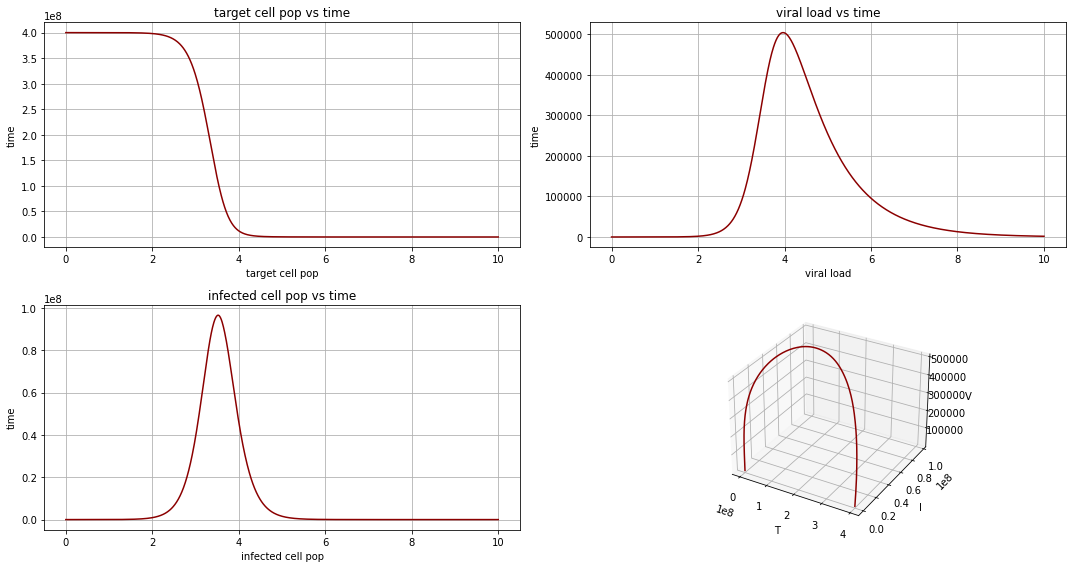

In [8]:
# STEP 7: use the results for something; here, plot the solutions

# This initializes a figure object
fig = plt.figure(figsize=(15,8))

# You need to put the code for the first three plots here

plt.subplot(2,2,1)
plt.plot(t, tar, color = 'darkred')
plt.title('target cell pop vs time')
plt.xlabel('target cell pop')
plt.ylabel('time')
plt.grid()

plt.subplot(2,2,2)
plt.plot(t, vir, color = 'darkred')
plt.title('viral load vs time')
plt.xlabel('viral load')
plt.ylabel('time')
plt.grid()

plt.subplot(2,2,3)
plt.plot(t, inf, color = 'darkred')
plt.title('infected cell pop vs time')
plt.xlabel('infected cell pop')
plt.ylabel('time')
plt.grid()


# A bit of the code necessary for the 3D plot is included here
# you need to fill in the arguments for the `plot` command though!
ax4 = plt.subplot(2,2,4, projection = '3d')
plt.plot(tar,inf,vir, color = 'darkred') # fill this in and make sure the order matches the labels below!
ax4.set_xlabel("T")
ax4.set_ylabel("I")
ax4.set_zlabel("V")

# Make sure to call this last. This command resizes the spaces between your plots to try to avoid overlap.
plt.tight_layout()

____
### Modeling

Now, think of a modeling question you have. For example, if the virion degradation rate $r$ were larger - what would happen? What if the initial viral load were much higher - what would happen? Phrase your question, change the initial conditions and/or parameters to answer your question, run the new model, and plot the results.

**Edit these next two lines with your question and what you changed:**
* My modeling question is: What if the propduction rate, p, were higher?
* I changed the basic model by: Increasing p
___

In [9]:
# Code for my new model.
def derivs(t, curr_vals, beta, delta, p_new, r):
    # unpack list of incoming variables
    target = curr_vals[0]
    infected = curr_vals[1]
    virions = curr_vals[2]

    # use variables to compute derivatives on the right-hand-side of the above equations
    # example: dTdt = < equation from above >
    dTdt = - beta*curr_vals[0]*curr_vals[2]
    dIdt = beta*curr_vals[0]*curr_vals[2]-delta*curr_vals[1]
    dVdt = p_new*curr_vals[1]-r*curr_vals[2]

    # return the derivatives in a list by changing the "pass" to "return" along with the correct list
    return [dTdt, dIdt, dVdt]

target_0 = 4e8
infected_0 = 0.0
virions_0 = 1.0
# Here we put them all into a list so that they can be passed to solve_ivp
initial = [target_0, infected_0, virions_0]

t = np.linspace(0,10,1000)

beta = 1e-5
delta = 4.0
p_new = 1e-1
r = 1

sol_new = solve_ivp(derivs, (0,10),initial,t_eval = t, args=(beta, delta, p_new, r))
tar_new = sol.y[0,:]
inf_new = sol.y[1,:]
vir_new = sol.y[2,:]

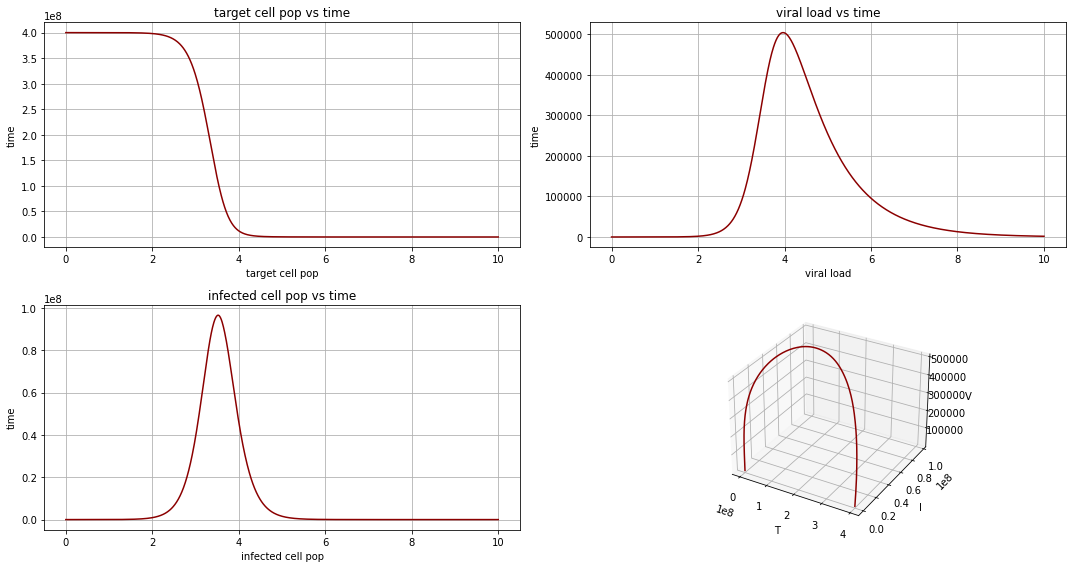

In [10]:
# Plot code for my new model
# This initializes a figure object
fig = plt.figure(figsize=(15,8))

# You need to put the code for the first three plots here

plt.subplot(2,2,1)
plt.plot(t, tar_new, color = 'darkred')
plt.title('target cell pop vs time')
plt.xlabel('target cell pop')
plt.ylabel('time')
plt.grid()

plt.subplot(2,2,2)
plt.plot(t, vir_new, color = 'darkred')
plt.title('viral load vs time')
plt.xlabel('viral load')
plt.ylabel('time')
plt.grid()

plt.subplot(2,2,3)
plt.plot(t, inf_new, color = 'darkred')
plt.title('infected cell pop vs time')
plt.xlabel('infected cell pop')
plt.ylabel('time')
plt.grid()


# A bit of the code necessary for the 3D plot is included here
# you need to fill in the arguments for the `plot` command though!
ax4 = plt.subplot(2,2,4, projection = '3d')
plt.plot(tar_new,inf_new,vir_new, color = 'darkred') # fill this in and make sure the order matches the labels below!
ax4.set_xlabel("T")
ax4.set_ylabel("I")
ax4.set_zlabel("V")

# Make sure to call this last. This command resizes the spaces between your plots to try to avoid overlap.
plt.tight_layout()

---
### Assignment wrapup

Please fill out the form that appears when you run the code below.  **You must completely fill this out in order to receive credit for the assignment!**

In [11]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://cmse.msu.edu/cmse201-pc-survey" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

### Congratulations, you're done!

Submit this assignment by uploading it to the course D2L web page.  Go to the "Pre-class assignments" folder, find the appropriate submission link, and upload it there.

See you in class!

___
### A worked example
___
Let's look at an example you can base your codes on and solve some equations. This example is for a simple oscillator system (think: spring or pendulum) where the effects of friction are included:

$$\frac{dx}{dt} = y,$$
$$\frac{dy}{dt} = -x-\theta y,$$
$$x(0) = x_0,$$
$$y(0) = y_0.$$

Finding a mathematical solution to this system is non-trivial, but thanks to `solve_ivp`, you mostly don't need to worry about this issue - let the computer do it! 

Below is a complete, worked example that you can use as a template for building a very wide range of ODE solutions. Notice that step 1 from above is already done - the equations in the standard form are provided.
___

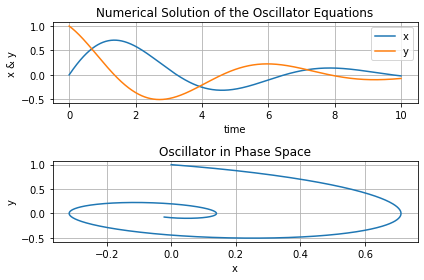

In [12]:
# IMPORTANT IMPORT COMMANDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

# Note that the SciPy library is needed for odeint
from scipy.integrate import solve_ivp

### CODE FOR ODE SOLUTION FOR OSCILLATOR
# STEP 2: define your ODE system of equations
def deriv_func(t, curr_vals, theta):
    
    # unpack list coming in that contains current values
    x = curr_vals[0]
    y = curr_vals[1]
    
    # the right-hand-side of the ODE system of equations
    dxdt = y
    dydt = -x - theta*y
    
    # send back the derivatives
    return [dxdt, dydt]

# STEP 3: setup up the initial conditions
x_0 = 0.0   # initial x
y_0 = 1.0   # initial y
ICs = [x_0, y_0]       # initial conditions, "ICs", in a list

# STEP 4: define time steps to use
time_grid  = np.linspace(0, 10., 1000)   # time grid

# STEP 5: define the any parameters needed for model
theta = 0.5 # we need to make sure we pass this to solve_ivp using the "args" keyword argument, see how in the code below

# STEP 6: solve the equations and access the solution
# solve the ODEs (finally!) by giving solve_ivp the derivative function,
# the initial conditions, and the grid over which we want a solution
solution = solve_ivp(deriv_func, (0,10), ICs, t_eval = time_grid, args=(theta,))  # note the syntax of this call to solve_ivp, especially the "args" part
# unpack the solution into its parts
x_vals = solution.y[0, :] # what does this slicing mean?
y_vals = solution.y[1, :]

# STEP 7: process your results (here, into visualization)
# let's see what we got! so much suspense!
plt.subplot(211)
plt.plot(time_grid, x_vals, label='x')
plt.plot(time_grid, y_vals, label='y')
plt.grid()
plt.xlabel('time')
plt.ylabel('x & y')
plt.title('Numerical Solution of the Oscillator Equations')
plt.legend(loc='best')

# plot the solution in phase space, which means plotting the variables versus 
# each other rather than versus time
plt.subplot(212)
plt.plot(x_vals,y_vals)
plt.grid()
plt.ylabel('y')
plt.xlabel('x')
plt.title('Oscillator in Phase Space')

plt.tight_layout()

&#169; Copyright 2018,  Michigan State University Board of Trustees